In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import itertools
import scipy
import random
from scipy import stats

# Первичный анализ данных

In [2]:
df = pd.read_csv("sensor.csv") 

https://www.kaggle.com/nphantawee/pump-sensor-data

Данные взяты из Kaggle.
Данные предоставлены командой, обслуживающей водяной насос. В таблице представлены данные 52-х сенсоров, замеры производились каждую минуту, с 1-ого апреля до 31-ого августа 2018 г. Данные также содержат отметки времени, а в последнем столбце указано состояние насоса: NORMAL, RECOVERING или BROKEN.

В период приведенных замеров насос выходил из строя 7 раз, что повлекло за собой большие проблемы для жителей города, которые используют этот насос. Поэтому наша цель: попытаться предсказать поломку насоса до того, как это произошло. Кажется, идея предсказания на основе временных рядов выглядит многообещающе. Попробуем применить алгоритмы классификации.

In [3]:
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [4]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

# Предобработка данных

Предобработка данных (2 балла) – выполнить необходимую агрегацию данных, убрать лишние поля и объекты, дать пояснения, если в предобработке данных нет необходимости – написать, почему.

In [5]:
import datetime

In [6]:
#подредактируем столбец с отметкми времени
df.sort_values('timestamp',axis = 0,inplace =True)
df['Datetime'] = pd.to_datetime(df.timestamp,format='%Y-%m-%d %H:%M:%S') 
df.index  = df.Datetime
df.drop('timestamp', axis = 1, inplace = True)
df.drop('Datetime', axis = 1, inplace = True)
df.head()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [7]:
#удалим неинформатиынй столбец Unnamed
df.drop('Unnamed: 0', axis = 1, inplace = True)

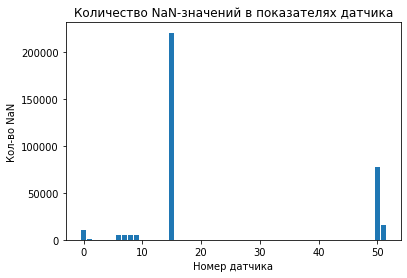

In [8]:
#исследуем данные на полноту - посчитаем количество Nan - значений для каждого датчика
sensors = list(df)[:-1];
nans = df[sensors].isnull().sum()
plt.figure()
plt.title("Количество NaN-значений в показателях датчика")
plt.bar(range(len(nans)), nans)
plt.xlabel("Номер датчика")
plt.ylabel("Кол-во NaN")
plt.show()

In [9]:
np.sort(nans)[-11:]

array([    72,    261,    369,   4595,   4798,   5107,   5451,  10208,
        15383,  77017, 220320], dtype=int64)

Видим, что можно удалить 10 столбцов. У всех остальных датчиков количество Nan-значений не превышает 100. Заполним их значениями, соответствующими медиане значений для конкретного датчика.

In [10]:
drop_sensors = np.array(sensors)[np.array(nans) > 100]
df.drop(drop_sensors, axis = 1, inplace = True)

In [11]:
sensors = list(df)[:-1]
for i in sensors:
    df[i].fillna(np.nanmedian(df[i]), inplace =True)

Закодируем target: NORMAL = 0, RECOVERING = 1, BROKEN = 2

In [12]:
target = np.array(df.machine_status)
target[target == 'NORMAL'] = 0
target[target == 'RECOVERING'] = 1
target[target == 'BROKEN'] = 2
df.machine_status = target

In [13]:
sensors_mean = []
for i in sensors:
    sensors_mean.append((np.nanmean(df[i])))
print("min: ", min(sensors_mean))
print("max: ", max(sensors_mean))

min:  2.303832949875766
max:  922.6135715666467


Все показатели датчиков - числа. По данным, полученным в предыдущей ячейке, видно, что значения показателей датчиков сильно разбросаны, что критично для некоторых алгортмов предсказания. Нормируем значения.

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
array = df.values 
X = array[:, :-1] 
Y = array[:, -1] 

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
rescaledX = scaler.fit_transform(X)  
np.set_printoptions(precision=8) 
rescaledX[:5, :5] 

array([[0.87665996, 0.88481635, 0.79224211, 0.76459842, 0.48914644],
       [0.87665996, 0.88481635, 0.79224211, 0.76459842, 0.48914644],
       [0.87665996, 0.89005221, 0.79790429, 0.73546068, 0.49756054],
       [0.87476255, 0.89005208, 0.78440219, 0.76989072, 0.5069158 ],
       [0.87665996, 0.89005208, 0.79485537, 0.76589062, 0.51886768]])

# Визуальный анализ данных

Для наглядности в визуализации используем данные без нормировки. Нормированные данные оставим для предсказания.

Посмотрим на типичные значения показаний для каждого датчика: 

Text(0.5, 0, 'Номер датчика')

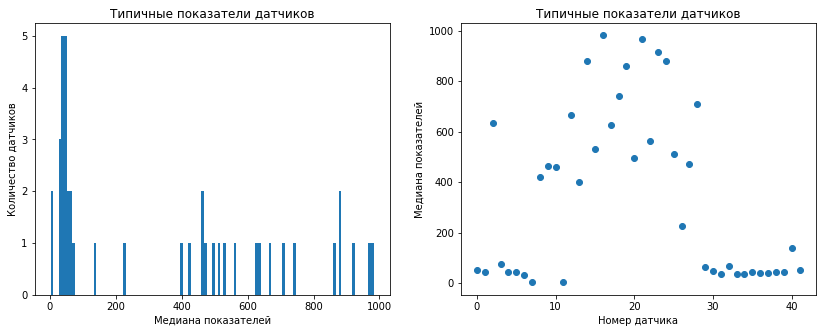

In [17]:
sensors = list(df)[:-1]
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(121)
plt.hist(np.nanmedian(df[sensors], axis = 0), bins = 120)
plt.title('Типичные показатели датчиков')
plt.xlabel('Медиана показателей')
plt.ylabel('Количество датчиков')

ах2 = fig.add_subplot(122)
plt.scatter(range(len(sensors)), np.nanmedian(df[sensors], axis = 0))
plt.title('Типичные показатели датчиков')
plt.ylabel('Медиана показателей')
plt.xlabel('Номер датчика')

Еще раз убедились в том, что разные датчики выдают совершенно разные показатели. Правда, большинство из датчиков показывают значения в диапазоне [0, 100].

Оценим репрезентативность данных:

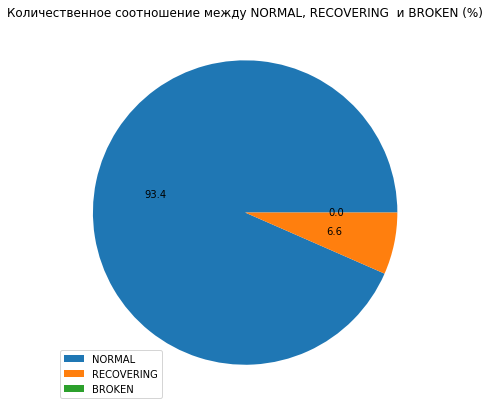

In [55]:
plt.figure(figsize=(10, 7))
plt.pie(list(df.machine_status.value_counts()), autopct='%.1f')
plt.legend(loc = 'lower left', labels = ['NORMAL', 'RECOVERING', 'BROKEN'])
plt.title('Количественное соотношение между NORMAL, RECOVERING  и BROKEN (%)')
plt.show()

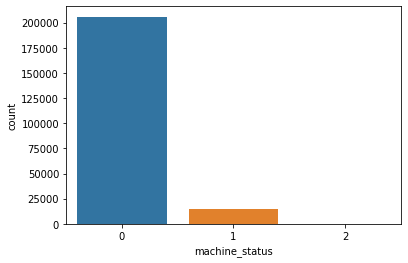

In [56]:
sns.countplot(x='machine_status', data=df);

Видим, что бОльшую часть составляют target-ы NORMAL. Значит, данные собраны неправильно - недостаточно хорошо отражают полную картину событий, а, значит, не стоит ожидать высокой точности предсказаний. Но попытаться стоит...

Теперь исследуем выбросы. Посмотрим на дисперсию и стандартное отклонение:

Text(0, 0.5, 'Стандартное отклонение')

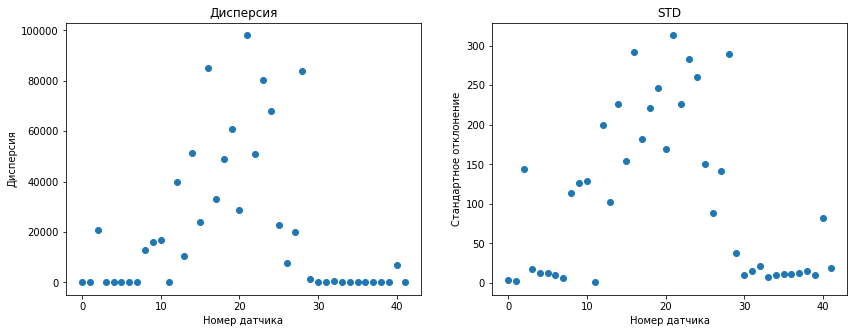

In [20]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
plt.scatter(range(len(sensors)), np.var(df[sensors], axis=0))
plt.title('Дисперсия')
plt.xlabel('Номер датчика')
plt.ylabel('Дисперсия')

ах2 = fig.add_subplot(122)
plt.scatter(range(len(sensors)), np.std(df[sensors], axis=0))
plt.title('STD')
plt.xlabel('Номер датчика')
plt.ylabel('Стандартное отклонение')

Видим, что вариабельность показателей датчиков 12 - 27 достаточно большая. Посмотрим еще на процентили:

Text(0.5, 0, 'Номер датчика')

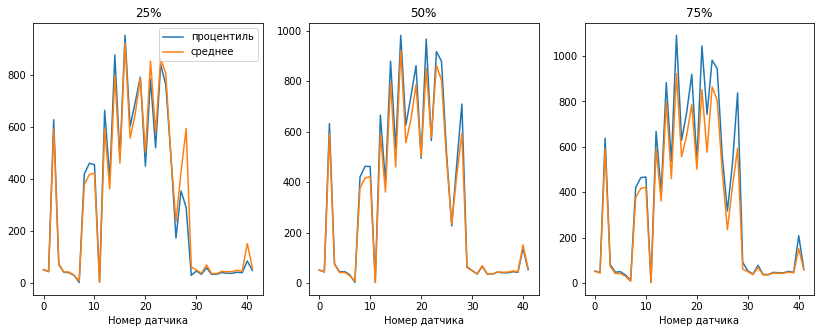

In [21]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(131)
plt.plot(range(len(sensors)), np.percentile(df[sensors], 25, axis=0),
        range(len(sensors)), np.mean(df[sensors], axis = 0))
plt.title('25%')
plt.xlabel('Номер датчика')
plt.legend(labels=['процентиль', 'среднее'])

ax2 = fig.add_subplot(132)
plt.plot(range(len(sensors)), np.percentile(df[sensors], 50, axis=0),
        range(len(sensors)), np.mean(df[sensors], axis = 0))
plt.title('50%')
plt.xlabel('Номер датчика')

ax1 = fig.add_subplot(133)
plt.plot(range(len(sensors)), np.percentile(df[sensors], 75, axis=0),
         range(len(sensors)), np.mean(df[sensors], axis = 0))
plt.title('75%')
plt.xlabel('Номер датчика')

Видим практически одинаковые графики для 25, 50, 75 процентилей. Наблюдаем(сравнивая с графиком средних значений) наибольшие отклонения все в тех же 15-25 датчиках. Но разница кажется небольшой, поэтому пока никаких мер по устранению выбросов принимать не будем. К тому же, может быть, как раз эти нетипичные значения показывают датчики при поломке насоса.

Посмотрим, какие значения показывают датчики: положительные или отрицательные?

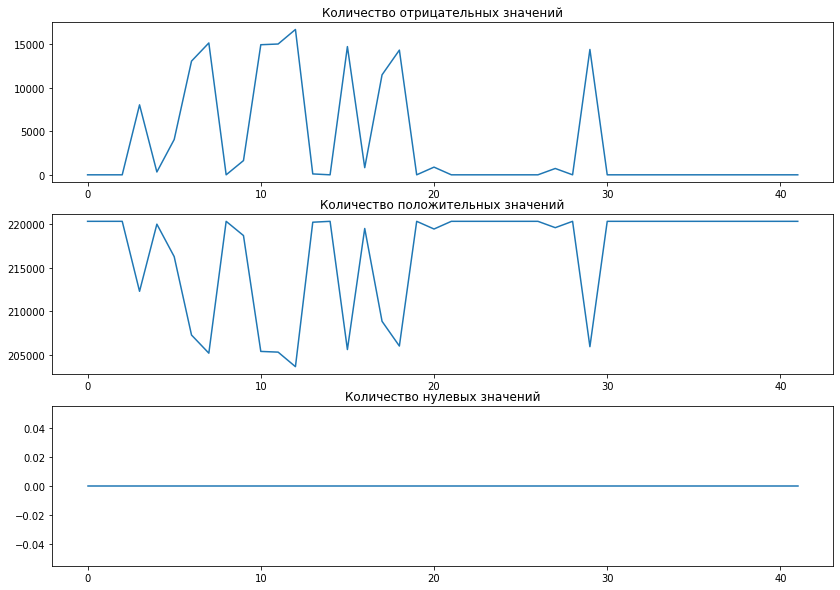

In [22]:
fig = plt.figure(figsize=(14, 10))

fig.add_subplot(311)
plt.plot(range(len(sensors)), np.sum(np.array(df[sensors]==0), axis=0))
plt.title("Количество отрицательных значений")
        
fig.add_subplot(312)
plt.plot(range(len(sensors)), np.sum(np.array(df[sensors]>0), axis=0))
plt.title("Количество положительных значений")

fig.add_subplot(313)
plt.plot(range(len(sensors)), np.sum(np.array(df[sensors]<0), axis=0))
plt.title("Количество нулевых значений")

plt.show()

Видим, что нулевых значений вообще нет, какие-то датчики показывают только положительные значения, какие-то - только отрицательные, а какие-то - и те и те. Это, например, значит, что если наш временной ряд окажется нестационарным, то преобразование Бокса-Кокса мы к нему применить не сможем.

Может быть показатели каких-либо датчиков корреллируют между собой? Попробуем это выяснить.

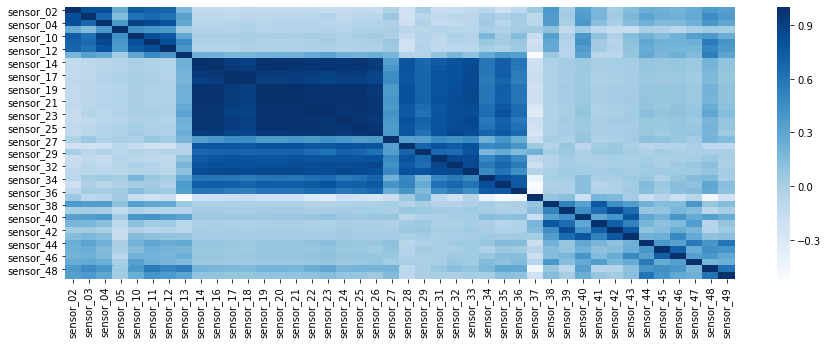

In [23]:
fig = plt.figure(figsize= (15,5))
sns.heatmap(df[sensors].corr(), cmap = 'Blues')

Видим, что показатели датчиков 14-25 очень сильно зависят друг от друга. Значит, можно будет оставить в датасете один из этих датчиков, а остальные удалить.  

In [24]:
bool_corr = abs(np.array(df[sensors].corr())) > 0.8
sensor_corr = np.array(sensors)[np.sum(bool_corr, axis=1) > 13]
sensor_corr

array(['sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_32', 'sensor_33'], dtype='<U9')

# Проверка статистических гипотез

**1. Проверка на нормальность распредления**

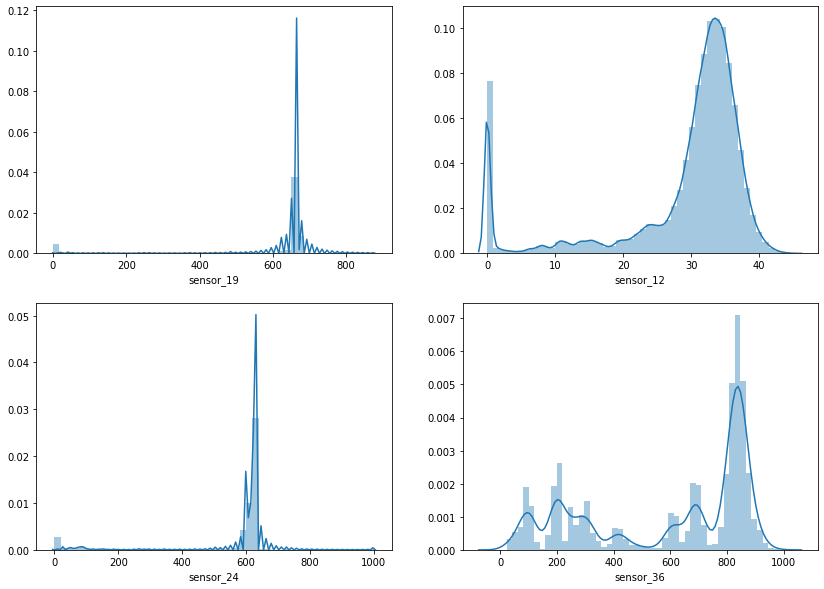

In [25]:
fig = plt.figure(figsize=(14, 10))
sample= random.sample(sensors, 4)
fig.add_subplot(221)
sns.distplot(df[sample[0]])

fig.add_subplot(222)
sns.distplot(df[sample[1]])

fig.add_subplot(223)
sns.distplot(df[sample[2]])

fig.add_subplot(224)
sns.distplot(df[sample[3]])

Посмотрим на цифры:

In [26]:
#тест Шапиро-Уилка
alpha = 0.05
normal = 0
for i in sensors:
    sensor = random.sample(list(df[i]), 5000)
    p =  stats.shapiro(sensor)
    if p[1] >=  alpha:   # Нулевая гипотеза: Данные распределены нормально
        normal += 1
normal

0

In [27]:
#тест Колмогорова-Смирнова
for i in sensors:
    p =  stats.kstest(df[i], 'norm')
    if p.pvalue >=  alpha:   # Нулевая гипотеза: Данные распределены нормально
        normal += 1
normal

0

Видим, что оба теста показали, что ни у одного датчика показатели не распредлены нормально. Посмотрим на Q-Q график: 

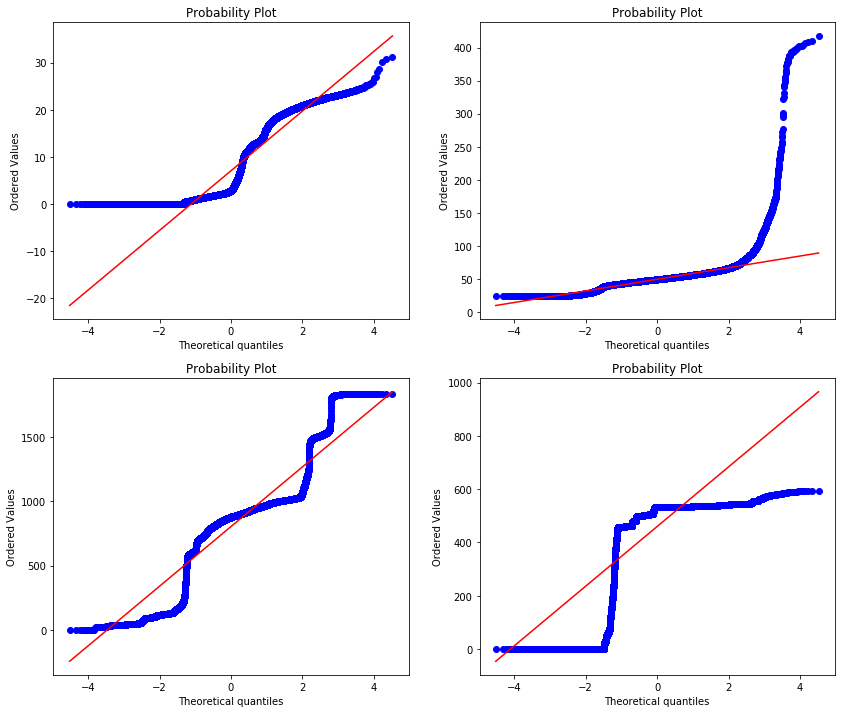

In [28]:
fig = plt.figure(figsize=(14, 12))
sample= random.sample(sensors, 4)
fig.add_subplot(221)
stats.probplot(df[sample[0]], dist = "norm", plot = plt)

fig.add_subplot(222)
stats.probplot(df[sample[1]], dist = "norm", plot = plt)

fig.add_subplot(223)
stats.probplot(df[sample[2]], dist = "norm", plot = plt)

fig.add_subplot(224)
stats.probplot(df[sample[3]], dist = "norm", plot = plt)
plt.show()

Удостоверились, что имеем дело с ненормально распределенными случаными величинами. Значит, параметрические статистические критерии применить нельзя.

**2. Свойства временного ряда**

Исследуем наш временной ряд.

Плавающее среднее. Наше распределение ненормально, поэтому исследуем медиану.

Сделаем декомпозицию временного ряда.

In [29]:
import statsmodels.api as sm
from pylab import rcParams

C:\Users\karry\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


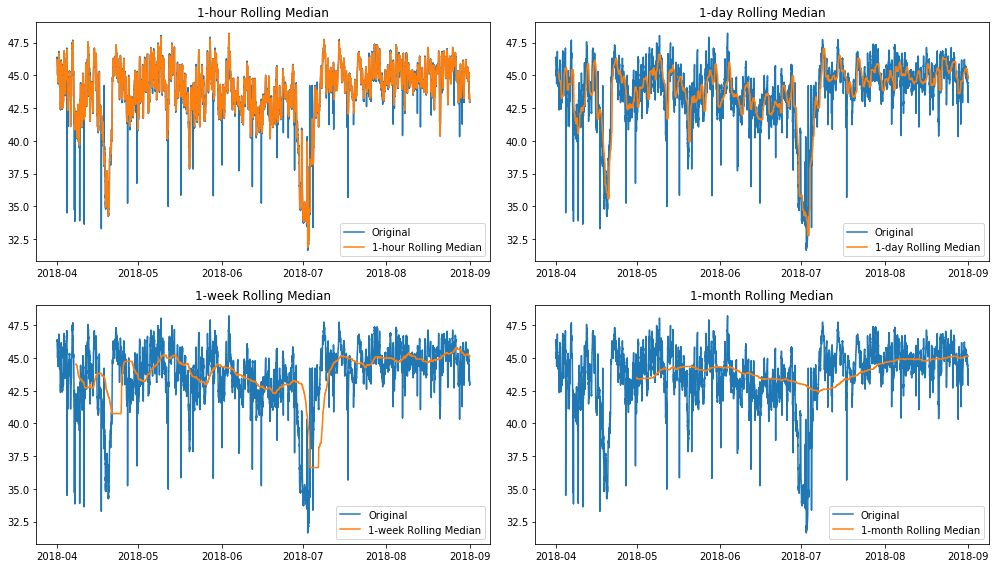

In [30]:
sample= random.sample(sensors, 1)

fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

window = 60
axes[0][0].plot(df.index, df[sample[0]], label='Original')
axes[0][0].plot(df.index, df[sample[0]].rolling(window=window).median(), label='1-hour Rolling Median')
axes[0][0].set_title("1-hour Rolling Median")
axes[0][0].legend(loc='best')

window = 24*60
axes[0][1].plot(df.index, df[sample[0]], label='Original')
axes[0][1].plot(df.index, df[sample[0]].rolling(window=window).median(), label='1-day Rolling Median')
axes[0][1].set_title("1-day Rolling Median")
axes[0][1].legend(loc='best')

window = 24*60*7
axes[1][0].plot(df.index, df[sample[0]], label='Original')
axes[1][0].plot(df.index, df[sample[0]].rolling(window=window).median(), label='1-week Rolling Median')
axes[1][0].set_title("1-week Rolling Median")
axes[1][0].legend(loc='best')

window = 24*60*30
axes[1][1].plot(df.index, df[sample[0]], label='Original')
axes[1][1].plot(df.index, df[sample[0]].rolling(window=window).median(), label='1-month Rolling Median')
axes[1][1].set_title("1-month Rolling Median")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

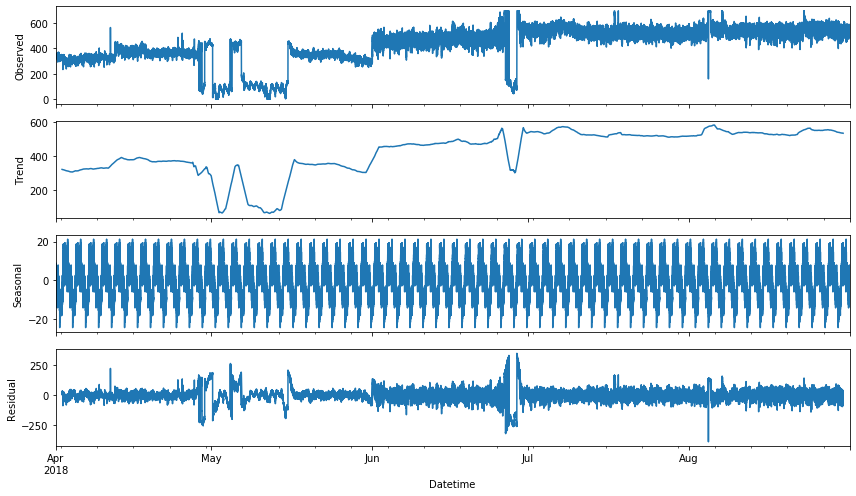

In [32]:
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(df[sample[0]], model='additive',freq= 24*30*5)
result.plot()
plt.show()

Тренда нет. Сезонность тоже проявляется слабо.

**3. Первая гипотеза. Непараметрический критерий.**

По графикам выше можно предположить, что показания датчиков увеличивались с течением времени. Разобьем вектор показаний датчика на две выборки: за апрель и за август. Проверим гипотезу:

H0: медианы показаний в авгусе и апреле совпадают

H1: медиана показаний в августе и апреле не совпадают

Попробуем применить двувыборочный непараметрический критерий Манна-Уитни для независимых выборок:

In [31]:
import statsmodels.stats.api as sms

Вычислим доверительный интервал для разности средних в апреле и августе для каждого датчика.

In [32]:
apr = df.loc[df.index.month == 4]
aug = df.loc[df.index.month == 8]
for i in sensors:
    cm = sms.CompareMeans(sms.DescrStatsW(aug[i]), sms.DescrStatsW(apr[i]))
    print([i, cm.tconfint_diff()])    

['sensor_02', (1.0613445234855257, 1.1353081897231383)]
['sensor_03', (1.831414065164553, 1.8844947633297822)]
['sensor_04', (62.35313743614127, 65.49069047362052)]
['sensor_05', (-0.5504343367866253, -0.09082343754198252)]
['sensor_10', (8.000930077598168, 8.247333594808937)]
['sensor_11', (8.263632748693183, 8.546393546880012)]
['sensor_12', (6.766759571668835, 6.995375363106028)]
['sensor_13', (9.305031976722596, 9.430665566519643)]
['sensor_14', (16.13432874856701, 17.313816222181547)]
['sensor_16', (14.232605934063846, 15.383967945905264)]
['sensor_17', (1.4361225668538542, 2.1790572921723164)]
['sensor_18', (0.009113420814170901, 0.017237927050237502)]
['sensor_19', (30.879353980214727, 33.20952041810806)]
['sensor_20', (16.209873070727504, 17.45994592684911)]
['sensor_21', (35.18162260121592, 37.93600341433937)]
['sensor_22', (72.5435565903008, 74.22923995222266)]
['sensor_23', (166.38869591574635, 169.67676009272859)]
['sensor_24', (15.776062783509047, 18.022844055394074)]
['se

C 95% вероятностью можем утверждать, что почти у всех датчиков показания увеличились на положительное число.

Попробуем применить двувыборочный непараметрический критерий Манна-Уитни для независимых выборок:

H0: P(apr > aug) < P(apr < aug) - вероятность того, что показатель датчика в апреле окажется меньше показателя датчика в августе равна вероятности того, что показатель датчика в апреле окажется больше показателя датчика в августе

H1: P(apr > aug) > P(apr < aug)

In [33]:
for i in sensors:
    print([i, stats.mannwhitneyu(apr[i].iloc[:100], aug[i].iloc[0:100], alternative = 'greater')])    

['sensor_02', MannwhitneyuResult(statistic=10000.0, pvalue=3.9309293236753553e-35)]
['sensor_03', MannwhitneyuResult(statistic=10000.0, pvalue=1.451855346059404e-35)]
['sensor_04', MannwhitneyuResult(statistic=3378.0, pvalue=0.99996323137699)]
['sensor_05', MannwhitneyuResult(statistic=6972.0, pvalue=7.280955019057828e-07)]
['sensor_10', MannwhitneyuResult(statistic=52.0, pvalue=1.0)]
['sensor_11', MannwhitneyuResult(statistic=5744.0, pvalue=0.03463420529582295)]
['sensor_12', MannwhitneyuResult(statistic=8347.0, pvalue=1.457098551639055e-16)]
['sensor_13', MannwhitneyuResult(statistic=0.0, pvalue=1.0)]
['sensor_14', MannwhitneyuResult(statistic=4649.0, pvalue=0.8047893124183187)]
['sensor_16', MannwhitneyuResult(statistic=4554.5, pvalue=0.8620893060638835)]
['sensor_17', MannwhitneyuResult(statistic=4828.0, pvalue=0.6632997128823909)]
['sensor_18', MannwhitneyuResult(statistic=4681.0, pvalue=0.7825000791774928)]
['sensor_19', MannwhitneyuResult(statistic=3939.0, pvalue=0.9952520262036

Видим, что pvalue для большинства датчиков принимает большое значение, значит, мы можем отвергнуть нулевую гипотезу и утверждать, что значения показателей в апреле меньше, чем в августе. Интересно, что есть датчики, например, под номерами 37, 45, 49, для которых мы должны принять нулевую гипотезу, то есть для этих приборов значения, наоборот, уменьшались.

Для убедительности применим критерий Уилкоксона:

H0: med(apr - aug) = 0

H1: med(apr - aug) != 0

In [34]:
for i in sensors:
    print([i, stats.wilcoxon(apr[i].iloc[:100], aug[i].iloc[0:100])])

['sensor_02', WilcoxonResult(statistic=0.0, pvalue=3.712434783080828e-18)]
['sensor_03', WilcoxonResult(statistic=0.0, pvalue=3.6609179466737685e-18)]
['sensor_04', WilcoxonResult(statistic=1373.0, pvalue=7.46502659616012e-05)]
['sensor_05', WilcoxonResult(statistic=1360.0, pvalue=6.184602932718626e-05)]
['sensor_10', WilcoxonResult(statistic=0.0, pvalue=3.896120241954008e-18)]
['sensor_11', WilcoxonResult(statistic=1439.0, pvalue=0.00018844280460731657)]
['sensor_12', WilcoxonResult(statistic=63.0, pvalue=2.5578312149691576e-17)]
['sensor_13', WilcoxonResult(statistic=0.0, pvalue=3.896120241954008e-18)]
['sensor_14', WilcoxonResult(statistic=2143.0, pvalue=0.1890340422934601)]
['sensor_16', WilcoxonResult(statistic=2209.0, pvalue=0.27725242148089646)]
['sensor_17', WilcoxonResult(statistic=2397.0, pvalue=0.6598601696863855)]
['sensor_18', WilcoxonResult(statistic=2392.0, pvalue=0.647456953314512)]
['sensor_19', WilcoxonResult(statistic=1753.0, pvalue=0.00794517741141279)]
['sensor_20'

pvalue близки к 0, поэтому, можем сказать, что значения датчиков в апреле и августе точно изменились.
Можно предположить, что это связано с износом аппаратуры, так как сезонности на графиках временного ряда мы не обнаружили. Из этого можно сделать вывод, что показания датчиков в июле-августе могут быть далеки от их истинных значений, что, отрицательно повлияет на точность предсказаний.

А еще выяснили, что наш временной ряд нестационарен по всем признакам.

**4. Вторая гипотеза.**

Посмотрим, в какое время происходили поломки насоса.

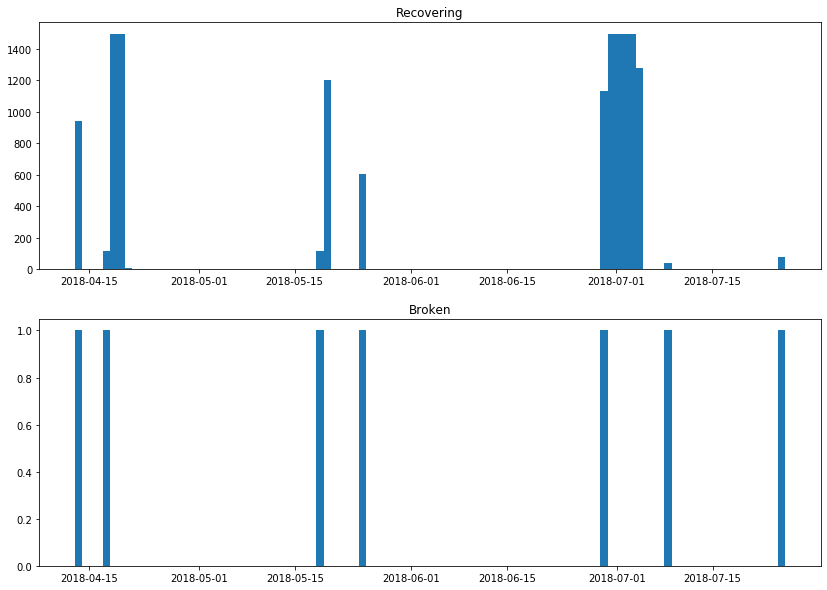

In [36]:
broken = df.loc[df.machine_status == 2]
recovering = df.loc[df.machine_status == 1]

fig = plt.figure(figsize=(14, 10))
fig.add_subplot(211)
plt.hist(recovering.index, bins=100)
plt.title('Recovering')

fig.add_subplot(212)
plt.hist(broken.index, bins=100)
plt.title('Broken')
plt.show()

Видно, что поломка и починка насоса происходила примерно в одно и то же время. Проверим гипотезу о том, что поломка происходила после починки. Для этого сравним нашу выборку из столбца machine_status с новой выборкой, в которой после починки идет поломка.

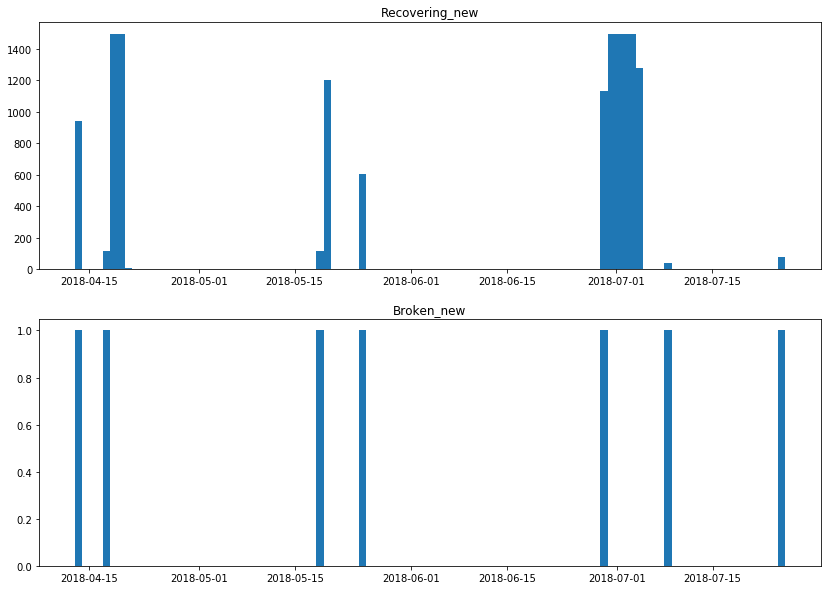

In [38]:
target = np.array(df.machine_status)
new_target = np.zeros(target.shape)
new_target[target==1] = 1
for i in range(len(new_target)-1):
    if new_target[i]==1 and new_target[i+1] != 1:
        new_target[i+1]=2

broken_new = new_target[new_target == 2]
recovering_new = new_target[new_target == 1]

fig = plt.figure(figsize=(14, 10))
fig.add_subplot(211)
plt.hist(recovering.index, bins=100)
plt.title('Recovering_new')

fig.add_subplot(212)
plt.hist(broken.index, bins=100)
plt.title('Broken_new')
plt.show()

Кажется, получилось похоже. Теперь применим к выборкам target и new_target двувыборочный непараметрический критерий. Снова применим критерий Манна-Уитни:

H0: P(target > new_target) = P(target < new_target) 

H1: P(target > new_target) != P(target < new_target)

In [39]:
stats.mannwhitneyu(target, new_target, alternative = 'two-sided')

MannwhitneyuResult(statistic=24270451200.0, pvalue=0.9999999779863428)

Критерий показал, что гипотеза H0 верна, как и предполагалось. Значит, гипотеза о том, что поломки происходили после починки нососа, верна.

# Предсказание временного ряда

Очевидно, что в нашем случаем подход "завтра = вчера" не сработает.

Для начал посмотрим на графики автокорреляции для одного из датчиков:

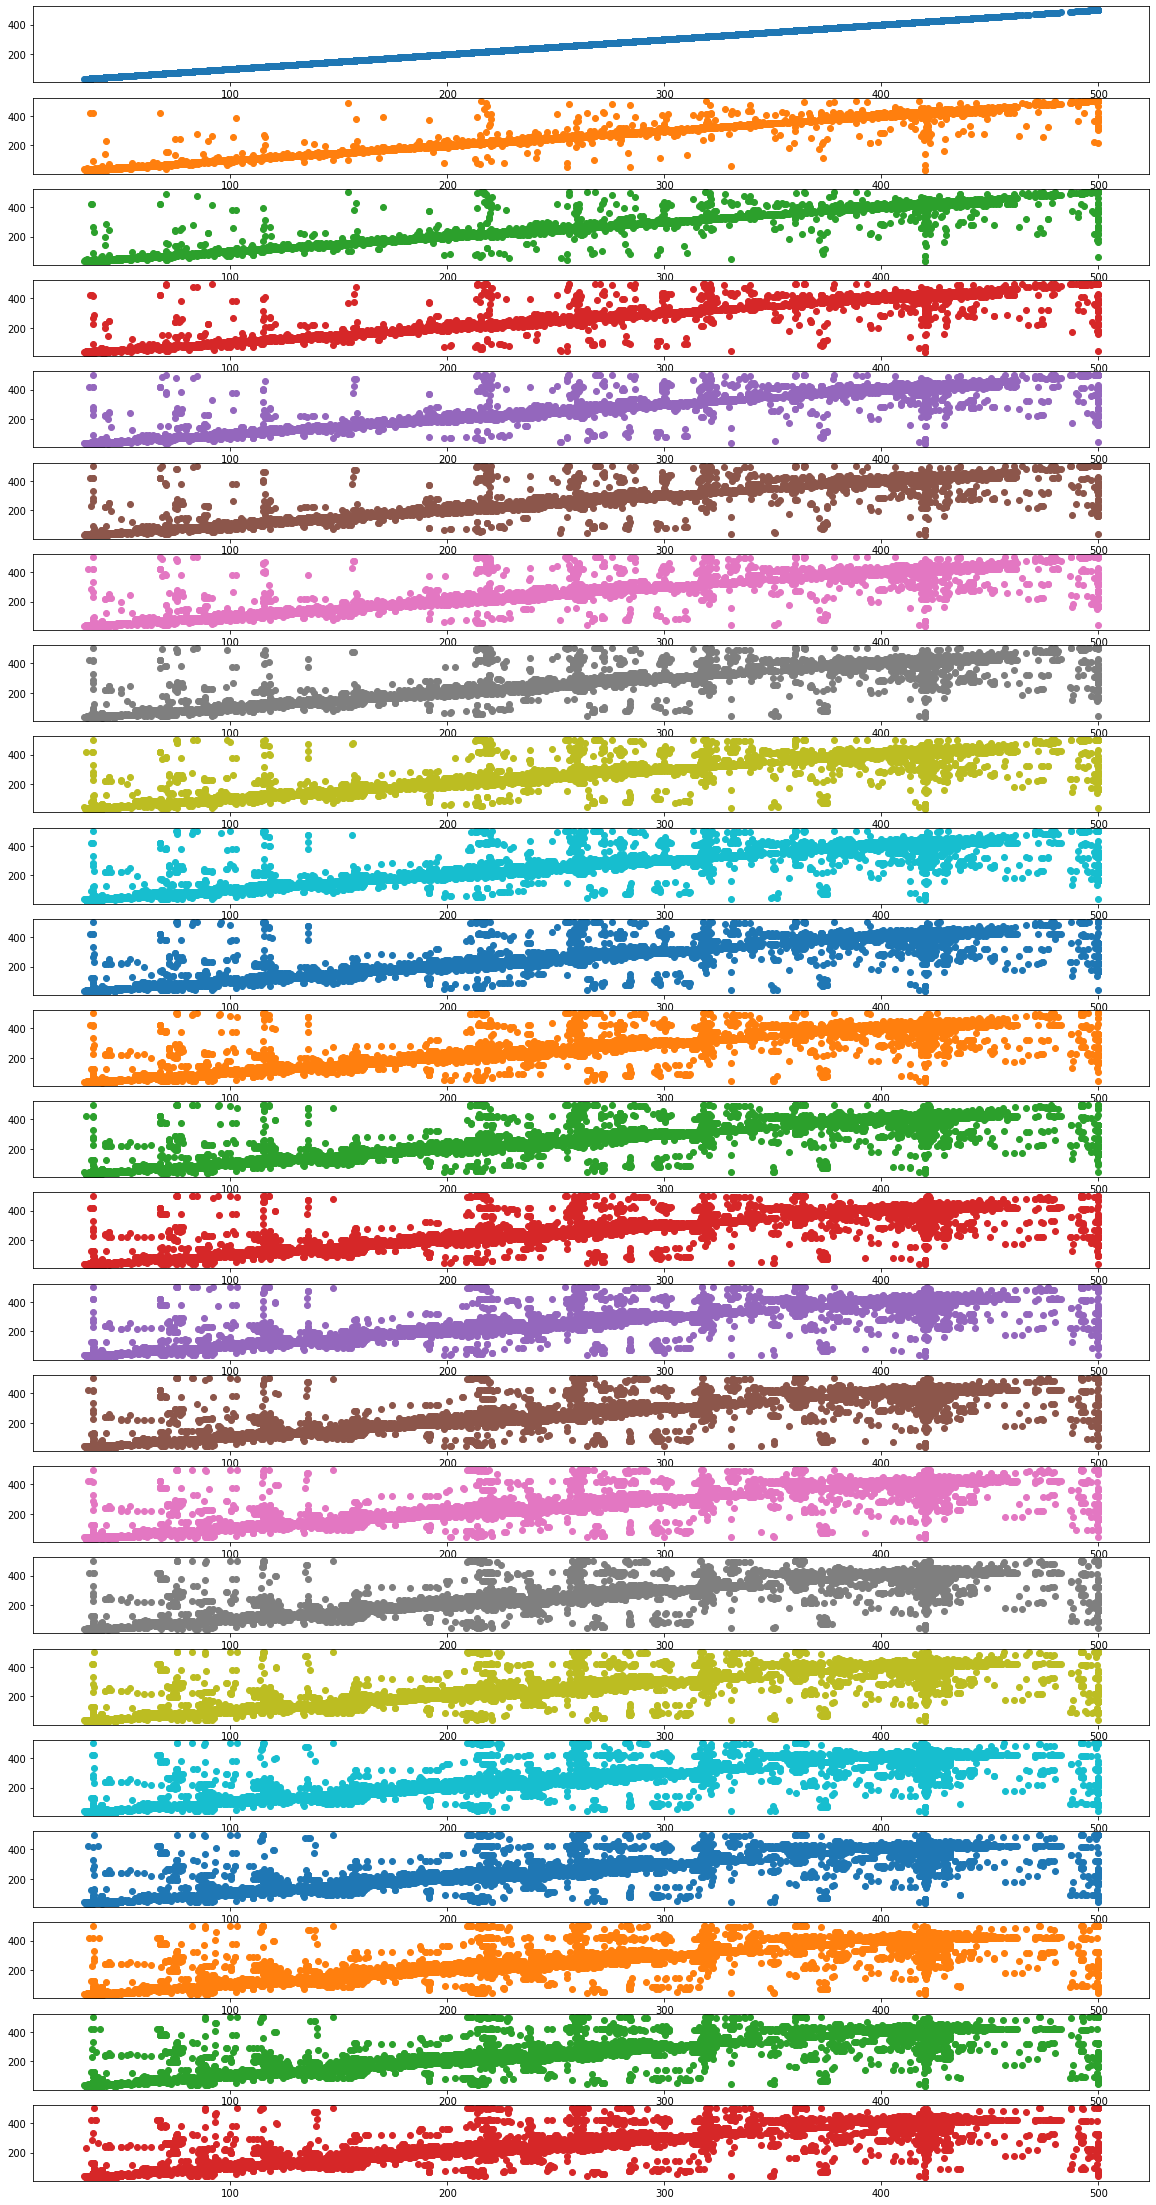

In [41]:
fig, axes = plt.subplots(24,1,figsize = (20,40))
sample = random.sample(sensors, 1)
for k, ax in enumerate(axes):
    for i in range(k):
        next(ax._get_lines.prop_cycler)
    ax.plot(df[sample[0]],df[sample[0]].shift(-k),'o')

plt.show()

Видим, что даже при большом сдвиге график автокорреляции не представляет собой нечто, похожее на прямую. Что еще раз доказывает отсутствие периодичности в наших данных.

Поэтому, в качестве алгоритма для предсказания возьмем логистическую регрессию. 

Добавим несколько дополнительных признаков:

In [42]:
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['weekday'] = df.index.weekday
df['is_weekend'] = df.weekday.isin([5,6])*1

In [43]:
df['mean'] = np.mean(df[sensors], axis=1)
df['max'] = np.max(df[sensors], axis=1)
df['min'] = np.min(df[sensors], axis=1)

Еще раз нормируем данные, а потом разобьем выборку на train и test части.

In [44]:
from sklearn.model_selection import TimeSeriesSplit

In [45]:
ind = list(df)
ind.remove('machine_status')

In [46]:
X = df[ind].to_numpy()
Y = df['machine_status'].to_numpy()
scaler = MinMaxScaler(feature_range=(0, 1)) 
rescaledX = scaler.fit_transform(X)  
np.set_printoptions(precision=8) 
rescaledX[:5, :5]

array([[0.87665996, 0.88481635, 0.79224211, 0.76459842, 0.48914644],
       [0.87665996, 0.88481635, 0.79224211, 0.76459842, 0.48914644],
       [0.87665996, 0.89005221, 0.79790429, 0.73546068, 0.49756054],
       [0.87476255, 0.89005208, 0.78440219, 0.76989072, 0.5069158 ],
       [0.87665996, 0.89005208, 0.79485537, 0.76589062, 0.51886768]])

In [47]:
n_split = 3
tscv = TimeSeriesSplit(n_splits=n_split)
Train = []
Test = []
for train, test in tscv.split(np.concatenate((rescaledX, Y.reshape(Y.shape[0], 1)), axis=1)):
    Train.append(train)
    Test.append(test)

X_train = []
Y_train = []
X_test = []
Y_test = []
for i in range(n_split):
    X_train.append(rescaledX[Train[i]])
    Y_train.append(Y[Train[i]])
    X_test.append(rescaledX[Test[i]])
    Y_test.append(Y[Test[i]])

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
clf = LogisticRegression(solver='newton-cg', multi_class='auto')
for i in range(n_split):
    clf.fit(X_train[i].astype(int), Y_train[i].astype(int))
    print(clf.score(X_test[i].astype(int), Y_test[i].astype(int)))

0.9631808278867102
0.8499636891793755
0.9986201888162672


Точность предсказаний довольно высокая - даже немного подозрительно...

Запустим алгоритм на всех данных:

In [50]:
predicted_ = clf.predict(rescaledX.astype(int))

In [51]:
clf.score(rescaledX.astype(int), Y.astype(int))

0.9353758169934641

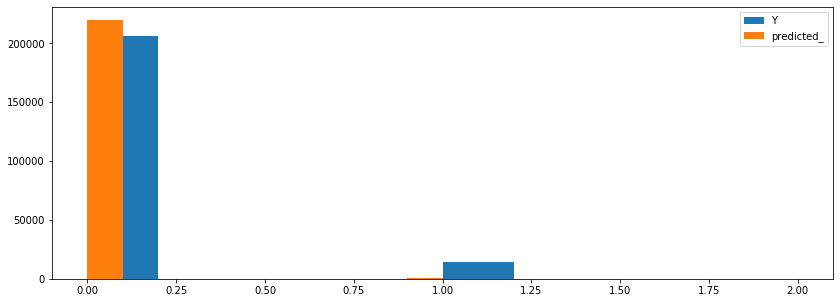

In [53]:
plt.figure(figsize=(14, 5))
plt.hist(Y)
plt.hist(predicted_)
plt.legend(labels=['Y', 'predicted_'])
plt.show()

Кажется, получилось неплохо.

# Выводы

Статистический анализ данных показал, что:

1) Механиики, занимающиеся починкой насоса, кажется, плохо ремонтируют его, так как мы выяснили, что насос ломается именно после поломки.

2) Можно предположить, что датчики имеют срок работы: чем дольше они функционируют, тем больше их показатели, и, скорее всего, показатели отдаляются от своих истинных значений. Можем предложить постановщикам задачи чаще менять датчики на новые.

3) Странно, что, несмотря на все минусы датасета, предсказания на нем получились довольно точные. Возможно, это связано с тем, что мы тестировали модель на данных за конец июля-авгус, где встречается больше всего починок. Может быть, это также связано с тем, мы использовали больше число признаков.